In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-10-29 21:33:57.792416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
data = yf.download("EQTL3.SA", start=start, end=end, auto_adjust=False)
print(data.columns)
print(data)


[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'EQTL3.SA'),
            (    'Close', 'EQTL3.SA'),
            (     'High', 'EQTL3.SA'),
            (      'Low', 'EQTL3.SA'),
            (     'Open', 'EQTL3.SA'),
            (   'Volume', 'EQTL3.SA')],
           names=['Price', 'Ticker'])
Price       Adj Close      Close       High        Low       Open    Volume
Ticker       EQTL3.SA   EQTL3.SA   EQTL3.SA   EQTL3.SA   EQTL3.SA  EQTL3.SA
Date                                                                       
2018-01-02  11.342074  13.128467  13.220359  13.024590  13.114484   2937471
2018-01-03  11.364512  13.154437  13.298266  13.044566  13.128467   2950987
2018-01-04  11.236458  12.984637  13.140453  12.876765  13.128467   7768179
2018-01-05  11.347094  13.112486  13.274295  12.910725  12.984637   4780649
2018-01-08  11.495762  13.284283  13.288278  13.084519  13.108491   4932328
...               ...        ...        ...        ...        ...       ...
2025-05-26  36.470001  36.470001  36.860001

In [72]:
import numpy as np
import pandas as pd
import yfinance as yf

symbol = "EQTL3.SA" #""
start = "2018-01-01"
end = "2025-06-01"
window_size = 365
threshold = 0.005  # 0.5% de variação para considerar alta/baixa

# ============================================
# 1. Download e limpeza inicial
# ============================================
data = yf.download(symbol, start=start, end=end, auto_adjust=False)

# Se vier com MultiIndex, pega só o nome do preço (nível 0)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

# Agora deve ter colunas simples: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# ============================================
# 2. Log-returns e datas
# ============================================
for col in ['Open', 'High', 'Low', 'Close']:
    data[f'{col}_ret'] = np.log((data[col] / data[col].shift(1)).replace(0, np.nan))
data['Volume_ret'] = np.log((data['Volume'] / data['Volume'].shift(1)).replace(0, np.nan))

data['DayOfYear'] = data.index.dayofyear
data['Month'] = data.index.month

# ============================================
# 3. Indicadores técnicos
# ============================================
data['EMA9']   = data['Close'].ewm(span=9, adjust=False).mean()
data['SMA20']  = data['Close'].rolling(window=20).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Momentum (30 dias)
data['Momentum'] = np.log(data['Close'] / data['Close'].shift(30))

# ============================================
# 4. Relações relativas e codificação temporal
# ============================================
data['Close_div_EMA9']   = data['Close'] / data['EMA9'] - 1
data['Close_div_SMA20']  = data['Close'] / data['SMA20'] - 1
data['Close_div_SMA200'] = data['Close'] / data['SMA200'] - 1

data['sin_day'] = np.sin(2 * np.pi * data['DayOfYear'] / 365)
data['cos_day'] = np.cos(2 * np.pi * data['DayOfYear'] / 365)

# Normalização de MACD por volatilidade (rolling std)
rolling_std = data['Close_ret'].rolling(window=60).std()
data['MACD_norm'] = (data['MACD'] - data['MACD'].rolling(60).mean()) / (rolling_std + 1e-8)
data['MACD_signal_norm'] = (data['MACD_signal'] - data['MACD_signal'].rolling(60).mean()) / (rolling_std + 1e-8)

# ============================================
# 5. Limpeza final
# ============================================
data = data.dropna()

# ============================================
# 6. Features finais e normalização
# ============================================
final_features = [
    'Open_ret','High_ret','Low_ret','Close_ret','Volume_ret',
    'Close_div_EMA9','Close_div_SMA20','Close_div_SMA200',
    'RSI','Momentum','sin_day','cos_day','MACD_norm','MACD_signal_norm'
]
"""
def rolling_normalize(X_window):
    mu = X_window.mean(axis=0)
    sigma = X_window.std(axis=0) + 1e-8
    return (X_window - mu) / sigma
"""
# ============================================
# 7. Construção das janelas (X, y)
# ============================================
X, y, window_dates = [], [], []
data_values = data[final_features].values
open_prices = data['Open'].values
close_prices = data['Close'].values


for i in range(window_size, len(data_values) - 1):
    window = data_values[i - window_size:i]
    # window = rolling_normalize(window)
    X.append(window)
    
    # Retorno futuro
    future_ret = (close_prices[i + 1] - open_prices[i + 1]) / open_prices[i + 1]
    if future_ret > threshold:
        label = 1
    elif future_ret < -threshold:
        label = 0
    
    y.append(label)
    window_dates.append(data.index[i])

# ============================================
# 8. Converter para numpy
# ============================================
X = np.array(X)
y = np.array(y)
window_dates = np.array(window_dates)

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Classes:", np.unique(y, return_counts=True))
print("Primeiras datas:", window_dates[:3])


[*********************100%***********************]  1 of 1 completed

Formato de X: (1275, 365, 14)
Formato de y: (1275,)
Classes: (array([0, 1]), array([647, 628]))
Primeiras datas: [Timestamp('2020-04-14 00:00:00') Timestamp('2020-04-15 00:00:00')
 Timestamp('2020-04-16 00:00:00')]


[ 2.15277786  2.16352441  2.15150527  2.08917205 -0.96019069  2.12038684
  2.10813706  1.46128205 -0.00564164  1.34480743 -0.29127731]


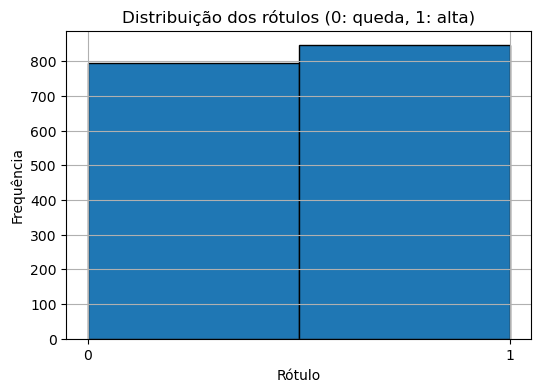

In [41]:
# Normalização dos dados
"""
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)  # Achata para aplicar a normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(n_samples, n_timesteps, n_features)

# Visualizando a distribuição dos rótulos
plt.figure(figsize=(6,4))
plt.hist(y, bins=2, edgecolor='k', align='mid')
plt.xticks([0, 1])
plt.title("Distribuição dos rótulos (0: queda, 1: alta)")
plt.xlabel("Rótulo")
plt.ylabel("Frequência")
plt.grid(True)
#plt.show()
print(X[-1][-1])  # primeira janela, primeira linha
"""

In [112]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
n_features = len(final_features)
print(len(X_train[0]))
print(y_train[0])

365
0


In [88]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Definição do modelo
model = Sequential([
    LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 2. Compilando o modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6484 - loss: 0.7076
Acurácia no conjunto de teste: 0.6484375
ïteration: 0
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.7317 - loss: 0.4996 - val_accuracy: 0.6565 - val_loss: 0.6278
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.7514 - loss: 0.4846 - val_accuracy: 0.6913 - val_loss: 0.6104
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.7459 - loss: 0.4902 - val_accuracy: 0.6609 - val_loss: 0.6381
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.7623 - loss: 0.4760 - val_accuracy: 0.6652 - val_loss: 0.6452
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.7699 - loss: 0.4539 - val_accuracy: 0.6348 - val_loss: 0.6515
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.7677 - loss: 0.4617 - val_accuracy: 0.6739 - val_loss: 0.6523
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.7699 - loss: 0.4681 - val_accur

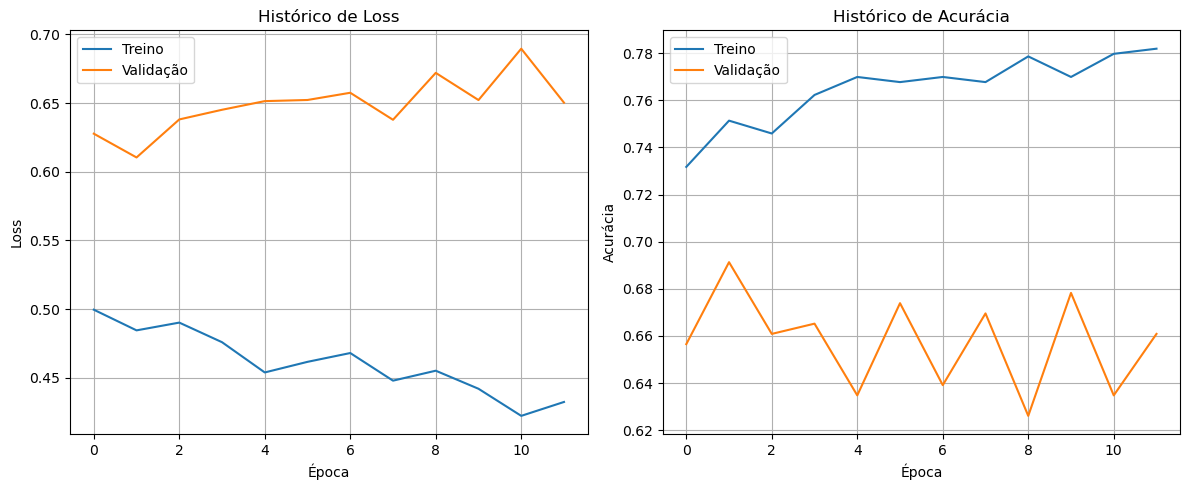

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6641 - loss: 0.7559
Acurácia no conjunto de teste: 0.6640625
ïteration: 1
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.7525 - loss: 0.4783 - val_accuracy: 0.6739 - val_loss: 0.6261
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.7688 - loss: 0.4735 - val_accuracy: 0.6696 - val_loss: 0.6360
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.7644 - loss: 0.4714 - val_accuracy: 0.6609 - val_loss: 0.6443
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.7655 - loss: 0.4664 - val_accuracy: 0.6304 - val_loss: 0.6617
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.7634 - loss: 0.4606 - val_accuracy: 0.6609 - val_loss: 0.6574
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.7699 - loss: 0.4501 - val_accuracy: 0.6652 - val_loss: 0.6363
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.7492 - loss: 0.4628 - val_accurac

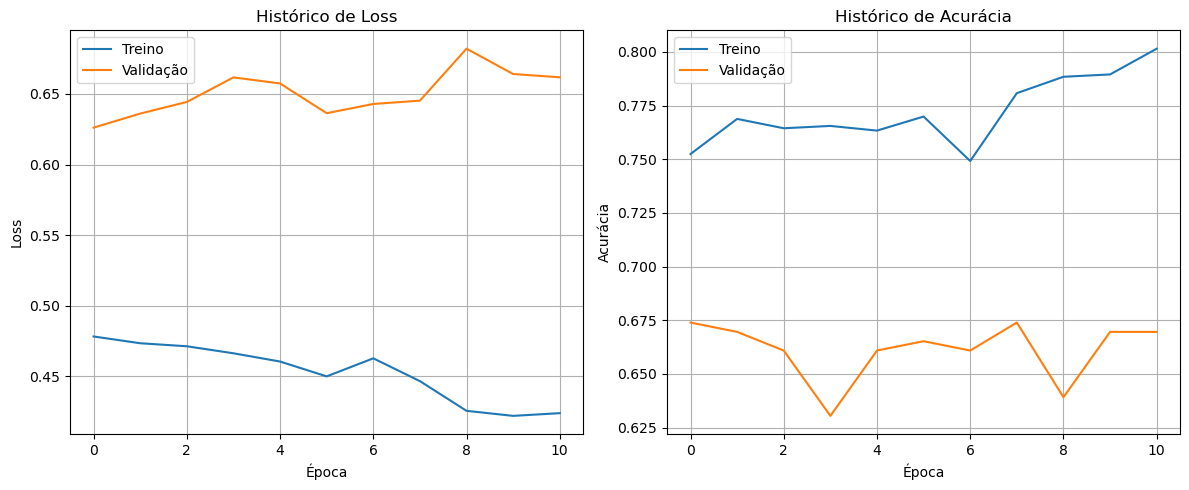

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6719 - loss: 0.7081
Acurácia no conjunto de teste: 0.671875
ïteration: 2
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.7601 - loss: 0.4897 - val_accuracy: 0.6826 - val_loss: 0.6291
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.7481 - loss: 0.4697 - val_accuracy: 0.6348 - val_loss: 0.6364
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.7623 - loss: 0.4583 - val_accuracy: 0.6957 - val_loss: 0.6080
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.7568 - loss: 0.4713 - val_accuracy: 0.6478 - val_loss: 0.6797
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7808 - loss: 0.4543 - val_accuracy: 0.6522 - val_loss: 0.6357
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.7852 - loss: 0.4372 - val_accuracy: 0.6565 - val_loss: 0.6548
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.7852 - loss: 0.4314 - val_accuracy

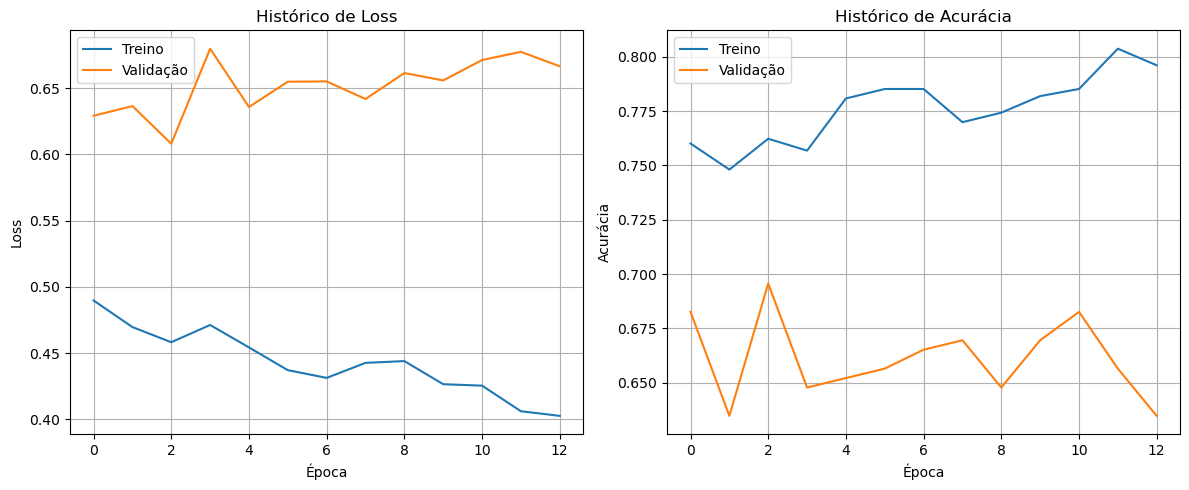

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6562 - loss: 0.7326
Acurácia no conjunto de teste: 0.65625
ïteration: 3
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.7764 - loss: 0.4379 - val_accuracy: 0.6696 - val_loss: 0.6553
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.7808 - loss: 0.4503 - val_accuracy: 0.6696 - val_loss: 0.6339
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - accuracy: 0.7634 - loss: 0.4467 - val_accuracy: 0.6565 - val_loss: 0.6748
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.7666 - loss: 0.4508 - val_accuracy: 0.6783 - val_loss: 0.6564
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.7786 - loss: 0.4347 - val_accuracy: 0.6870 - val_loss: 0.6253
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.7775 - loss: 0.4229 - val_accuracy: 0.6391 - val_loss: 0.6474
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.7928 - loss: 0.4194 - val_accura

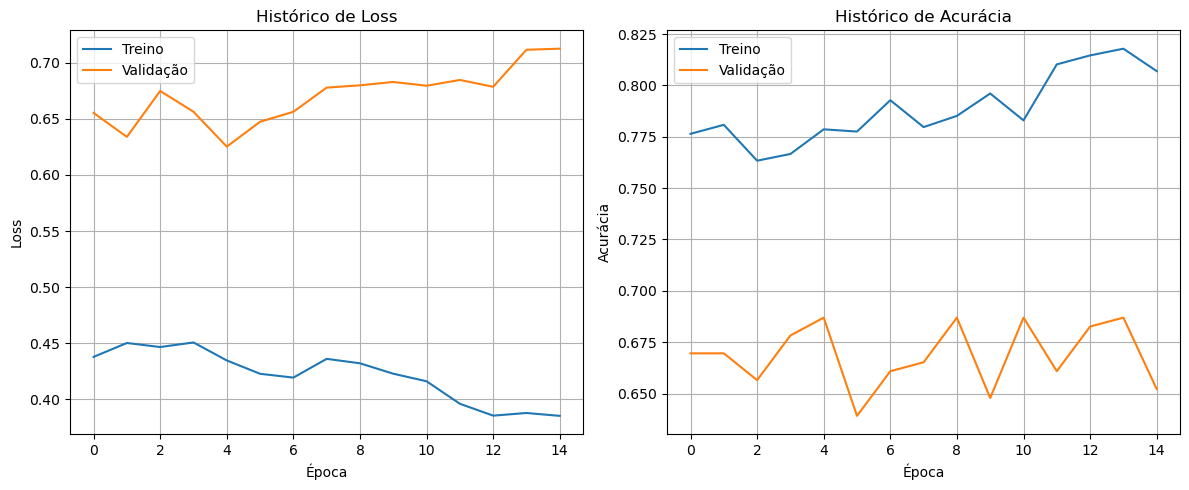

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6484 - loss: 0.7941
Acurácia no conjunto de teste: 0.6484375
ïteration: 4
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.7939 - loss: 0.4235 - val_accuracy: 0.6391 - val_loss: 0.6755
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.7928 - loss: 0.4204 - val_accuracy: 0.6304 - val_loss: 0.6480
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.7830 - loss: 0.4228 - val_accuracy: 0.6696 - val_loss: 0.6616
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.7808 - loss: 0.4188 - val_accuracy: 0.6435 - val_loss: 0.6809
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.7950 - loss: 0.4097 - val_accuracy: 0.6522 - val_loss: 0.6673
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.8070 - loss: 0.3977 - val_accuracy: 0.6913 - val_loss: 0.6818
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.7983 - loss: 0.3966 - val_accurac

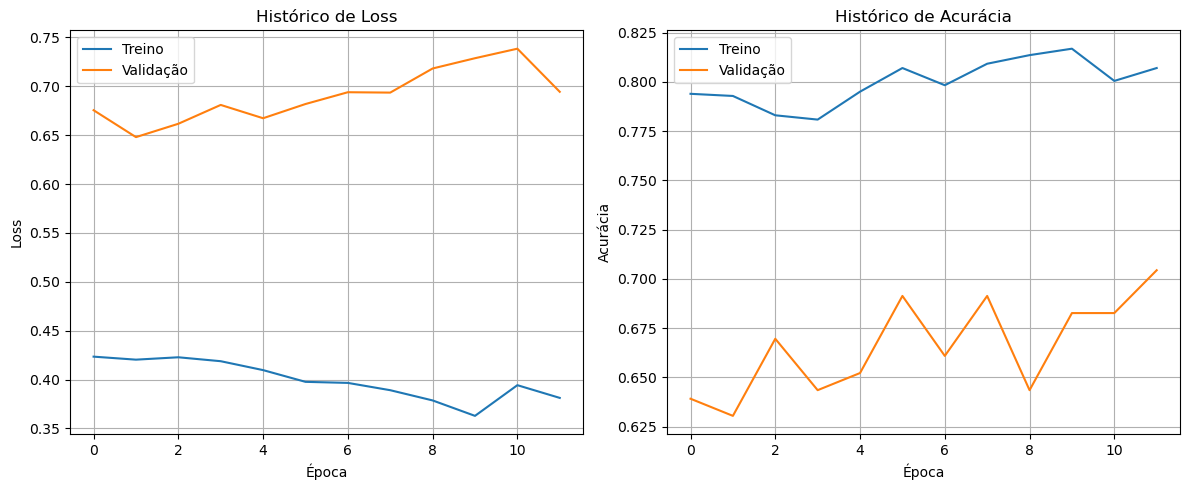

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6641 - loss: 0.8150
Acurácia no conjunto de teste: 0.6640625
ïteration: 5
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.7917 - loss: 0.4271 - val_accuracy: 0.6522 - val_loss: 0.6682
Epoch 2/100
 5/29 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.8233 - loss: 0.3904

KeyboardInterrupt: 

In [118]:
loss, acc = model.evaluate(X_test, y_test)
print("Acurácia no conjunto de teste:", acc)
for i in range(100):
    print(f'ïteration: {i}'  )
    early_stop = EarlyStopping(
        monitor='val_loss',      
        patience=10,              
        restore_best_weights=True,  
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
    f'best_model{i}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
    )
    
    
    # 5. Treinamento do modelo com EarlyStopping
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop]
    )
    model.save(f'MODEL_2layersLSTM_2Dense_iteration{i}.keras')
    
    # Plot do histórico de treinamento
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title("Histórico de Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title("Histórico de Acurácia")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Avaliação do modelo no conjunto de teste
    loss, acc = model.evaluate(X_test, y_test)
    print("Acurácia no conjunto de teste:", acc)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,       # redução suave
    patience=20,      # espera mais antes de reduzir LR
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [reduce_lr, checkpoint]

# --- Treinamento ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,         # treino longo
    batch_size=64,       # acelera e suaviza treino
    callbacks=callbacks,
    verbose=2            # menos poluição no log
)

In [22]:
# Após o treinamento, para obter as probabilidades no conjunto de teste:
predicted_probabilities = model.predict(X_test)

# Exibir as probabilidades para os 5 primeiros exemplos:
for i, prob in enumerate(predicted_probabilities[:5]):
    print(f"Amostra {i}: Probabilidade de alta = {prob[0]:.2f}")
    
# Caso você queira converter para um sinal (subir/descender) utilizando um threshold de 0.5:
predicted_signals = (predicted_probabilities.flatten() > 0.5).astype(int)
print("Sinais previstos (0: baixa, 1: alta) para os 5 primeiros exemplos:", predicted_signals[:5])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Amostra 0: Probabilidade de alta = 0.52
Amostra 1: Probabilidade de alta = 0.99
Amostra 2: Probabilidade de alta = 1.00
Amostra 3: Probabilidade de alta = 0.76
Amostra 4: Probabilidade de alta = 0.60
Sinais previstos (0: baixa, 1: alta) para os 5 primeiros exemplos: [1 1 1 1 1]


In [110]:
model.save("MODEL_2layersLSTM_2Dense_0.66.keras")


In [26]:
model.summary()
loss, acc = model.evaluate(X_test, y_test)
print("Acurácia no conjunto de teste:", acc)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.65 KB)

 Trainable params: 25,313 (98.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,628 (197.77 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4810 - loss: 1.6227
Acurácia no conjunto de teste: 0.4810126721858978


In [108]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)
